In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time

In [2]:
img = cv2.imread("data/dennoban_20181224.png")

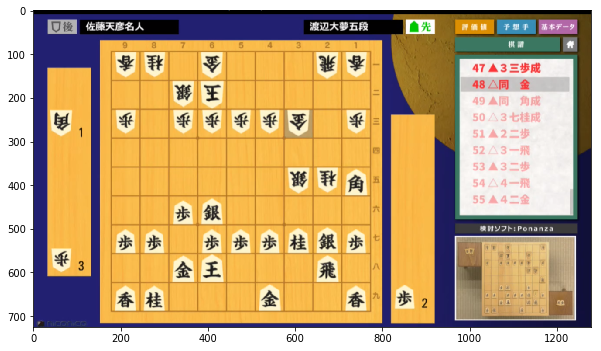

In [3]:
def display_cv2_img(img, figsize=(10,10)):
    plt.figure(figsize=figsize)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)

display_cv2_img(img)

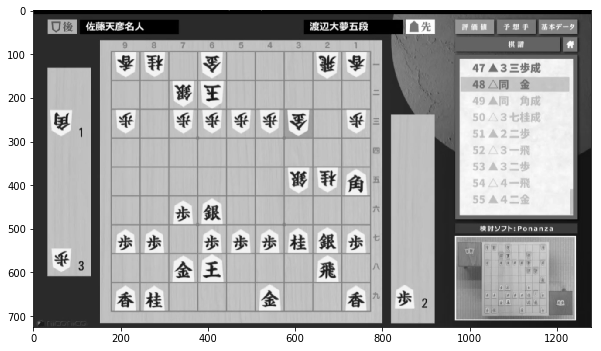

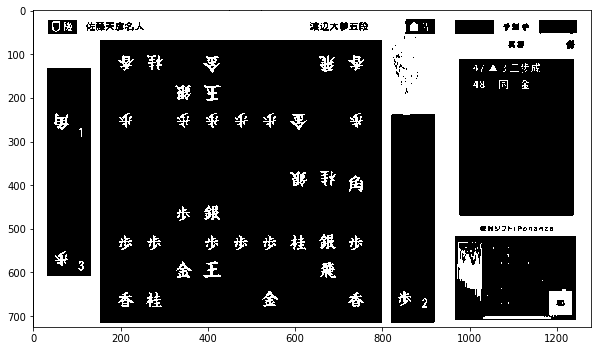

In [4]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
display_cv2_img(img_gray)

img_blur = img_gray#  cv2.GaussianBlur(img_gray, (11, 11), 0) #(C)
img_threshold = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
display_cv2_img(img_threshold)

In [5]:
def get_bounding_box(contour):
    contour = np.reshape(contour, (-1, 2))
    min_pt = np.min(contour, axis=0)
    max_pt = np.max(contour, axis=0)
    return min_pt[0], min_pt[1], max_pt[0], max_pt[1]
    
def error_bb_size(bb, gt_size):
    bb_w, bb_h = bb[2] - bb[0], bb[3] - bb[1]
    gt_w, gt_h = gt_size
    return abs(bb_w - gt_w) + abs(bb_h - gt_h)

def bounding_box_for_gt_size(bbs, gt_size, take_size=1):
    errors = [error_bb_size(bb, gt_size) for bb in bbs]
    bes = list(zip(enumerate(bbs), errors))
    sorted_bes = sorted(bes, key=lambda be: be[1])
    return [be[0][1] for be in sorted_bes[:take_size]]

def bounding_box_for_main_board(bbs):
    gt_size = 648, 648
    return bounding_box_for_gt_size(bbs, gt_size, take_size=1)[0]

def bounding_boxes_for_komadai(bbs):
    gt_size = 101, 479
    ret_bbs = bounding_box_for_gt_size(bbs, gt_size, take_size=2)
    if ret_bbs[0][0] < ret_bbs[1][0]:
        return ret_bbs[0], ret_bbs[1]
    return ret_bbs[1], ret_bbs[0]

contours = cv2.findContours(img_threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[1]
bbs = [get_bounding_box(c) for c in contours]    
bb_mb = bounding_box_for_main_board(bbs)
bb_kd_gote, bb_kd_sente = bounding_boxes_for_komadai(bbs)

print("============================")
print(" BOUNDING BOXES")
print("============================")
print("main board:", *bb_mb)
print("komadai(sente):", *bb_kd_sente)
print("komadai(gote):", *bb_kd_gote)

 BOUNDING BOXES
main board: 152 68 800 716
komadai(sente): 820 237 921 716
komadai(gote): 32 131 133 609


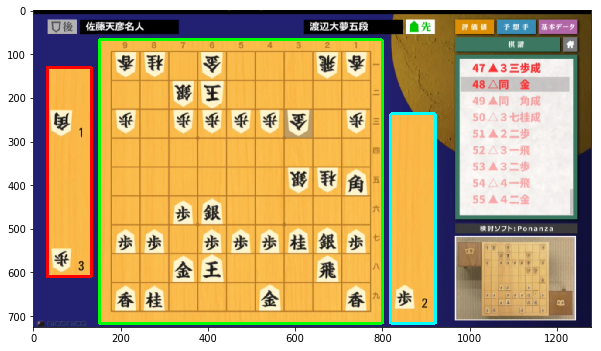

In [6]:
# visualize 

def bounding_box_to_contour(bb):
    return np.array([
        (bb[0], bb[1]),
        (bb[0], bb[3]),
        (bb[2], bb[3]),
        (bb[2], bb[1]),
        (bb[0], bb[1]),
    ])

img_cont = img.copy()
img_cont = cv2.drawContours(img_cont, [bounding_box_to_contour(bb_mb)], -1, (0,255,0), 6)
img_cont = cv2.drawContours(img_cont, [bounding_box_to_contour(bb_kd_sente)], -1, (255,255,0), 6)
img_cont = cv2.drawContours(img_cont, [bounding_box_to_contour(bb_kd_gote)], -1, (0,0,255), 6)
display_cv2_img(img_cont)

main_board


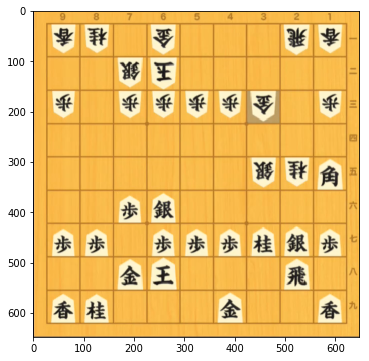

komadai_sente


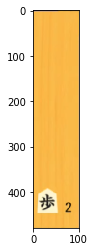

komadai_gote


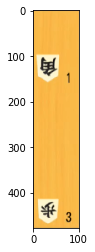

In [7]:
main_board = img[bb_mb[1]:bb_mb[3], bb_mb[0]:bb_mb[2]]
display_cv2_img(main_board, figsize=(6,6))
print("main_board")
plt.show()

komadai_sente = img[bb_kd_sente[1]:bb_kd_sente[3], bb_kd_sente[0]:bb_kd_sente[2]]
display_cv2_img(komadai_sente, figsize=(4,4))
print("komadai_sente")
plt.show()

komadai_gote= img[bb_kd_gote[1]:bb_kd_gote[3], bb_kd_gote[0]:bb_kd_gote[2]]
display_cv2_img(komadai_gote, figsize=(4,4))
print("komadai_gote")
plt.show()

## 将棋盤

at (1, 1)


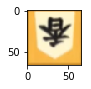

at (5, 5)


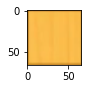

at (9, 9)


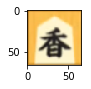

In [8]:
# split main board image into 9x9 cell images

offset_x = 27
offset_y = 27
cell_h = 66
cell_w = 66

def get_cell(main_board, cell_x, cell_y):
    x1 = offset_x + cell_w * cell_x
    x2 = offset_x + cell_w * (1 + cell_x)
    y1 = offset_y + cell_h * cell_y
    y2 = offset_y + cell_h * (1 + cell_y)
    if len(img.shape) == 3:
        return main_board[y1:y2,x1:x2,:]
    return main_board[y1:y2,x1:x2]

cells = []
for y in range(9):
    for x in range(9):
        cells.append(get_cell(main_board, x, y))

display_cv2_img(cells[0], figsize=(1,1))
print("at (1, 1)")
plt.show()

display_cv2_img(cells[40], figsize=(1,1))
print("at (5, 5)")
plt.show()

display_cv2_img(cells[80], figsize=(1,1))
print("at (9, 9)")
plt.show()


In [16]:
# [(img_path, piece name, "v" if gote, piece name JP)]
piece_info = [
    ("data/hu.png",  " 歩"),
    ("data/hi.png", " 飛"),
    ("data/kaku.png", " 角"),
    ("data/kyo.png", " 香"),
    ("data/kei.png", " 桂"),
    ("data/gin.png", " 銀"),
    ("data/kin.png", " 金"),
    ("data/gyoku.png", " 玉"),
    ("data/empty.png", " ・"),
    ("data/hu.png", "v歩"),
    ("data/hi.png", "v飛"),
    ("data/kaku.png", "v角"),
    ("data/kyo.png", "v香"),
    ("data/kei.png", "v桂"),
    ("data/gin.png", "v銀"),
    ("data/kin.png", "v金"),
    ("data/gyoku.png", "v玉"),
]

pieces = [cv2.imread(path) for path, _ in piece_info]
# flip if gote's piece
for i in range(len(pieces)):
    if piece_info[i][1][0] == "v":
        pieces[i] = cv2.flip(pieces[i], -1)

def classify_pieces(cell):
    scores = []
    for i, piece in enumerate(pieces):
        res = cv2.matchTemplate(cell, piece, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        scores.append((i, max_val, piece_info[i]))
    sorted_scores = sorted(scores, key=lambda sc: sc[1])
    return sorted_scores[-1]

preds = []
for i, cell in enumerate(cells):
    piece = classify_pieces(cell)
    preds.append(piece[2])

print(preds[0])

('data/kyo.png', 'v香')


In [20]:
# compare grand truth
gts = [
    "v香", "v桂", " ・", "v金", " ・", " ・", " ・", "v飛", "v香",
    " ・", " ・", "v銀", "v玉", " ・", " ・", " ・", " ・", " ・",
    "v歩", " ・", "v歩", "v歩", "v歩", "v歩", "v金", " ・", "v歩",
    " ・", " ・", " ・", " ・", " ・", " ・", " ・", " ・", " ・",
    " ・", " ・", " ・", " ・", " ・", " ・", "v銀", "v桂", " 角",
    " ・", " ・", " 歩", " 銀", " ・", " ・", " ・", " ・", " ・",
    " 歩", " 歩", " ・", " 歩", " 歩", " 歩", " 桂", " 銀", " 歩",
    " ・", " ・", " 金", " 玉", " ・", " ・", " ・", " 飛", " ・",
    " 香", " 桂", " ・", " ・", " ・", " 金", " ・", " ・", " 香",
]

ok = True
for i, (pred, gt) in enumerate(zip(preds, gts)):
    if pred[1] != gt:
        print(i, pred[1], "!=", gt)
        ok = False
if ok:
    print("all predictions are correct.")

all predictions are correct.


## Komadai (Sente)

歩 -> 0.9927184581756592 | (9, 389)
飛 -> 0.5211061835289001 | (6, 385)
角 -> 0.5930103659629822 | (6, 390)
香 -> 0.6578074097633362 | (5, 388)
桂 -> 0.5291094779968262 | (4, 386)
銀 -> 0.5424246788024902 | (6, 385)
金 -> 0.6135522723197937 | (5, 388)
[(0, 0.9927184581756592, (9, 389, 57, 446), ('data/hu.png', '歩'))]


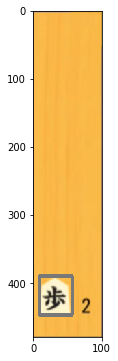

In [23]:
komadai_piece_info = [
    ("data/hu.png", "歩"),
    ("data/hi.png", "飛"),
    ("data/kaku.png", "角"),
    ("data/kyo.png", "香"),
    ("data/kei.png", "桂"),
    ("data/gin.png", "銀"),
    ("data/kin.png", "金"),
]

komadai_piece_colors = [
    (120, 120, 120),
    (0, 0, 255),
    (255, 0, 0),
    (0, 0, 100),
    (100, 0, 0),
    (200, 200, 200),
    (0, 255, 255),
]

pieces = [cv2.imread(path) for path, _ in komadai_piece_info]

def detect_pieces(komadai):
    piece_locs = []
    for i, piece in enumerate(pieces):
        res = cv2.matchTemplate(komadai, piece, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(res)
        if max_val >= 0.95:
            bb = max_loc[0], max_loc[1], max_loc[0] + piece.shape[1], max_loc[1] + piece.shape[0]
            piece_locs.append((i, max_val, bb, komadai_piece_info[i]))
        print(komadai_piece_info[i][1], "->", max_val, "|", max_loc)
    return piece_locs

sente_komadai_pieces = detect_pieces(komadai_sente)
print(sente_komadai_pieces)

komadai_rendered = komadai_sente.copy()
for i, _, bb, _ in sente_komadai_pieces:
    komadai_rendered = cv2.drawContours(komadai_rendered, [bounding_box_to_contour(bb)], -1, komadai_piece_colors[i], 3)
display_cv2_img(komadai_rendered, figsize=(6,6))

歩 -> 0.9901034832000732 | (8, 414)
飛 -> 0.7433230876922607 | (5, 97)
角 -> 0.9858334064483643 | (6, 97)
香 -> 0.6511241793632507 | (8, 412)
桂 -> 0.5909742116928101 | (5, 99)
銀 -> 0.655007004737854 | (7, 97)
金 -> 0.694473922252655 | (6, 101)
[(0, 0.9901034832000732, (8, 414, 56, 471), ('data/hu.png', '歩')), (2, 0.9858334064483643, (6, 97, 60, 159), ('data/kaku.png', '角'))]


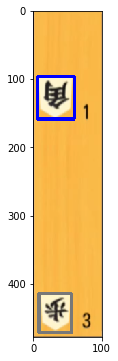

In [24]:
pieces = [cv2.flip(cv2.imread(path), -1) for path, _ in komadai_piece_info]
gote_komadai_pieces = detect_pieces(komadai_gote)
print(gote_komadai_pieces)
komadai_rendered = komadai_gote.copy()
for i, _, bb, _ in gote_komadai_pieces:
    komadai_rendered = cv2.drawContours(komadai_rendered, [bounding_box_to_contour(bb)], -1, komadai_piece_colors[i], 3)
display_cv2_img(komadai_rendered, figsize=(6,6))

In [25]:
print(preds)
print(sente_komadai_pieces)
print(gote_komadai_pieces)

[('data/kyo.png', 'v香'), ('data/kei.png', 'v桂'), ('data/empty.png', ' ・'), ('data/kin.png', 'v金'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/hi.png', 'v飛'), ('data/kyo.png', 'v香'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/gin.png', 'v銀'), ('data/gyoku.png', 'v玉'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/hu.png', 'v歩'), ('data/empty.png', ' ・'), ('data/hu.png', 'v歩'), ('data/hu.png', 'v歩'), ('data/hu.png', 'v歩'), ('data/hu.png', 'v歩'), ('data/kin.png', 'v金'), ('data/empty.png', ' ・'), ('data/hu.png', 'v歩'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png', ' ・'), ('data/empty.png',

In [27]:

# write kif
lines = [
    "後手の持駒：", 
    "  ９ ８ ７ ６ ５ ４ ３ ２ １",
    "+---------------------------+",
    "|v香v桂v銀v金v玉v金v銀v桂v香|一",
    "| ・v飛 ・ ・ ・ ・ ・v角 ・|二",
    "|v歩 ・ ・v歩v歩v歩v歩v歩v歩|三",
    "| ・v歩 ・ ・ ・ ・ ・ ・ ・|四",
    "| ・ ・ ・ ・ ・ ・ ・ ・ ・|五",
    "| ・ ・ ・ ・ ・ ・ ・ ・ ・|六",
    "| 歩 歩 歩 歩 歩 歩 歩 歩 歩|七",
    "| ・ 角 ・ ・ ・ ・ ・ 飛 ・|八",
    "| 香 桂 銀 金 玉 金 銀 桂 香|九",
    "+---------------------------+",
    "先手の持駒：なし",
    "先手：",
    "後手：",
    "手数----指手---------消費時間--",
]

if len(sente_komadai_pieces) >= 1:
    lines[13] = "先手の持駒：" + " ".join([p[-1][1] for p in sente_komadai_pieces])
else:
    lines[13] = "先手の持駒：なし"

if len(gote_komadai_pieces) >= 1:
    lines[0] = "後手の持駒：" + " ".join([p[-1][1] for p in gote_komadai_pieces])
else:
    lines[0] = "後手の持駒：なし"
    
for y in range(9):
    line = "|"
    for x in range(9):
        p = preds[y * 9 + x]
        line += p[1]
    line += lines[3+y][-2:]
    lines[3+y] = line

print("\n".join(lines))

後手の持駒：歩 角
  ９ ８ ７ ６ ５ ４ ３ ２ １
+---------------------------+
|v香v桂 ・v金 ・ ・ ・v飛v香|一
| ・ ・v銀v玉 ・ ・ ・ ・ ・|二
|v歩 ・v歩v歩v歩v歩v金 ・v歩|三
| ・ ・ ・ ・ ・ ・ ・ ・ ・|四
| ・ ・ ・ ・ ・ ・v銀v桂 角|五
| ・ ・ 歩 銀 ・ ・ ・ ・ ・|六
| 歩 歩 ・ 歩 歩 歩 桂 銀 歩|七
| ・ ・ 金 玉 ・ ・ ・ 飛 ・|八
| 香 桂 ・ ・ ・ 金 ・ ・ 香|九
+---------------------------+
先手の持駒：歩
先手：
後手：
手数----指手---------消費時間--
